In [2]:
import sys
sys.path.append("../code/")
from common import APPLIANCES_ORDER
import warnings 
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
tensor = np.load('../1H-input.npy')

In [5]:
def create_subset_dataset(tensor):
    t_subset = tensor[:, :, 180:194, :]
    all_indices = np.array(list(range(320)))
    for i in range(1, 7):
        valid_homes = pd.DataFrame(t_subset[:, i, :].reshape(320, 14*24)).dropna().index
        all_indices = np.intersect1d(all_indices, valid_homes)
    t_subset = t_subset[all_indices, :, :, :].reshape(52, 7, 14*24)
    
    # Create artificial aggregate
    t_subset[:, 0, :] = 0.0
    for i in range(1, 7):
        t_subset[:, 0, :] = t_subset[:, 0, :] + t_subset[:, i, :]
    # t_subset is of shape (#home, appliance, days*hours)
    return t_subset, all_indices

In [6]:
t_all, valid_homes = create_subset_dataset(tensor)
t_all.shape

(52, 7, 336)

In [7]:
t_all.shape

(52, 7, 336)

In [8]:
def my_objective(y_pred, y_true):
    with tf.name_scope(None):
        return tf.losses.absolute_difference(y_pred, y_true)

In [9]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
import keras
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
n_movies = 3
n_users=3
n_latent_factors=2

Using TensorFlow backend.


In [10]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

In [108]:
train_agg = t_all[:30, 0, :].reshape(30*14, 24)
train_appliance = t_all[:30, 1:, :].reshape(30*14, 6*24)

train_hvac = t_all[:30, 1, :].reshape(30*14, 24)
train_fridge = t_all[:30, 2, :].reshape(30*14, 24)
train_mw = t_all[:30, 3, :].reshape(30*14, 24)
train_dw = t_all[:30, 4, :].reshape(30*14, 24)
train_wm = t_all[:30, 5, :].reshape(30*14, 24)
train_oven = t_all[:30, 6, :].reshape(30*14, 24)








train_agg_new = train_hvac + train_fridge





test_hvac = t_all[30:, 1, :].reshape(22*14, 24)
test_fridge = t_all[30:, 2, :].reshape(22*14, 24)
test_mw = t_all[30:, 3, :].reshape(22*14, 24)
test_dw = t_all[30:, 4, :].reshape(22*14, 24)
test_wm = t_all[30:, 5, :].reshape(22*14, 24)
test_oven = t_all[30:, 6, :].reshape(22*14, 24)
test_appliance = t_all[30:, 1:, :].reshape(22*14, 6*24)









test_agg = t_all[30:, 0, :].reshape(22*14, 24)
test_agg_new = test_hvac + test_fridge



In [109]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

In [115]:
train_hvac_fridge = np.hstack([train_hvac, train_fridge])
train_all_appliances = np.hstack([train_hvac, train_fridge, train_mw, train_dw, train_wm, train_oven])
test_all_appliances = np.hstack([test_hvac, test_fridge, test_mw, test_dw, test_wm, test_oven])

In [116]:
train_all_appliances.shape, test_all_appliances.shape

((420, 144), (308, 144))

In [112]:
np.allclose(train_all_appliances, train_appliance)

False

In [61]:
ENERGY_MEAN = {APPLIANCES_ORDER[i]:np.mean(t_all[:, i, :]) for i in list(range(1, 7))}
ENERGY_MEAN = pd.Series(ENERGY_MEAN)
ENERGY_MEAN.sort_values(inplace=True, ascending=False)
ENERGY_MEAN

hvac      894.701044
fridge     89.265252
oven       16.646041
dw         13.984549
mw          6.417846
wm          5.083840
dtype: float64

In [62]:
np.random.seed(0)
from keras.layers.merge import Subtract, Minimum, Multiply, Maximum
import keras.backend as K

layers = {}
appliance="hvac"


In [262]:
np.random.seed(0)
layers['Aggregate'] = keras.layers.Input(shape=[24],name='Aggregate')
for appliance_num, appliance in enumerate(ENERGY_MEAN.index[:]):
    if appliance_num==0:
        prev = 'Aggregate'
        layers['{}-dense'.format(appliance)] = keras.layers.Dense(units=20,name='{}-layer-1'.format(appliance), activation='relu')(layers['Aggregate'])
    else:
        prev = 'Subtracting-{}'.format(ENERGY_MEAN.index[appliance_num-1])
        layers['{}-dense'.format(appliance)] = keras.layers.Dense(units=20,name='{}-layer-1'.format(appliance), activation='relu')(layers[prev])
    print(appliance, prev)
    layers['{}-dropout'.format(appliance)] = keras.layers.Dropout(rate=0.1,name='Droput-{}'.format(appliance))(layers['{}-dense'.format(appliance)])
    layers['{}-output'.format(appliance)]= keras.layers.Dense(units=24,name='{}-output'.format(appliance), activation='relu')(layers['{}-dropout'.format(appliance)])
    layers['{}-clipped-output'.format(appliance)] = Minimum(name='Clipped-{}'.format(appliance))([layers['{}-output'.format(appliance)], layers['Aggregate']])
    
    # Subtracting out appliance from prev
    layers['Subtracting-{}'.format(appliance)] = Subtract(name='Subtracting-{}'.format(appliance))([layers[prev], layers['{}-clipped-output'.format(appliance)]])
    




concat = keras.layers.merge([layers['{}-clipped-output'.format(appliance)] for appliance in APPLIANCES_ORDER[1:]], mode='concat',name='Concat')
model = keras.Model(layers['Aggregate'], concat )

with open('tree.pdf','wb') as f:
    f.write(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='pdf'))



#SVG(model_to_dot(model,  show_shapes=False, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

hvac Aggregate
fridge Subtracting-hvac
oven Subtracting-fridge
dw Subtracting-oven
mw Subtracting-dw
wm Subtracting-mw


In [263]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Aggregate (InputLayer)          (None, 24)           0                                            
__________________________________________________________________________________________________
hvac-layer-1 (Dense)            (None, 20)           500         Aggregate[0][0]                  
__________________________________________________________________________________________________
Droput-hvac (Dropout)           (None, 20)           0           hvac-layer-1[0][0]               
__________________________________________________________________________________________________
hvac-output (Dense)             (None, 24)           504         Droput-hvac[0][0]                
__________________________________________________________________________________________________
Clipped-hv

In [264]:
np.random.seed(0)
model.compile('adam','mean_absolute_error')
model.fit(train_agg, train_all_appliances, epochs=2000, validation_split=0.1)

Train on 378 samples, validate on 42 samples
Epoch 1/2000
378/378 [==============================] - 3s 9ms/step - loss: 259.3444 - val_loss: 239.8792
Epoch 2/2000
378/378 [==============================] - 0s 131us/step - loss: 214.6353 - val_loss: 200.5159
Epoch 3/2000
378/378 [==============================] - 0s 139us/step - loss: 176.3073 - val_loss: 166.2251
Epoch 4/2000
378/378 [==============================] - 0s 140us/step - loss: 143.7865 - val_loss: 136.7294
Epoch 5/2000
378/378 [==============================] - 0s 136us/step - loss: 116.8717 - val_loss: 113.7115
Epoch 6/2000
378/378 [==============================] - 0s 135us/step - loss: 97.8363 - val_loss: 97.2235
Epoch 7/2000
378/378 [==============================] - 0s 160us/step - loss: 83.8354 - val_loss: 84.9449
Epoch 8/2000
378/378 [==============================] - 0s 135us/step - loss: 74.3178 - val_loss: 75.7906
Epoch 9/2000
378/378 [==============================] - 0s 205us/step - loss: 67.8812 - val_loss: 6

Epoch 77/2000
378/378 [==============================] - 0s 129us/step - loss: 38.1731 - val_loss: 42.2522
Epoch 78/2000
378/378 [==============================] - 0s 141us/step - loss: 37.9182 - val_loss: 42.3405
Epoch 79/2000
378/378 [==============================] - 0s 123us/step - loss: 37.9703 - val_loss: 42.4616
Epoch 80/2000
378/378 [==============================] - 0s 150us/step - loss: 38.0840 - val_loss: 42.4402
Epoch 81/2000
378/378 [==============================] - 0s 116us/step - loss: 37.9368 - val_loss: 42.4578
Epoch 82/2000
378/378 [==============================] - 0s 120us/step - loss: 37.9914 - val_loss: 42.4847
Epoch 83/2000
378/378 [==============================] - 0s 126us/step - loss: 37.8447 - val_loss: 42.4869
Epoch 84/2000
378/378 [==============================] - 0s 135us/step - loss: 37.7324 - val_loss: 42.4614
Epoch 85/2000
378/378 [==============================] - 0s 134us/step - loss: 37.7931 - val_loss: 42.4440
Epoch 86/2000
378/378 [==============

378/378 [==============================] - 0s 128us/step - loss: 36.8044 - val_loss: 40.8155
Epoch 153/2000
378/378 [==============================] - 0s 121us/step - loss: 36.9889 - val_loss: 40.9074
Epoch 154/2000
378/378 [==============================] - 0s 197us/step - loss: 36.9862 - val_loss: 40.8738
Epoch 155/2000
378/378 [==============================] - 0s 161us/step - loss: 36.9718 - val_loss: 40.7932
Epoch 156/2000
378/378 [==============================] - 0s 233us/step - loss: 36.9964 - val_loss: 40.6545
Epoch 157/2000
378/378 [==============================] - 0s 265us/step - loss: 36.8551 - val_loss: 40.7230
Epoch 158/2000
378/378 [==============================] - 0s 132us/step - loss: 36.9066 - val_loss: 40.9438
Epoch 159/2000
378/378 [==============================] - 0s 139us/step - loss: 36.8025 - val_loss: 40.9730
Epoch 160/2000
378/378 [==============================] - 0s 146us/step - loss: 36.7767 - val_loss: 40.6323
Epoch 161/2000
378/378 [===================

Epoch 228/2000
378/378 [==============================] - 0s 111us/step - loss: 36.0196 - val_loss: 40.8327
Epoch 229/2000
378/378 [==============================] - 0s 117us/step - loss: 36.0879 - val_loss: 40.9386
Epoch 230/2000
378/378 [==============================] - 0s 105us/step - loss: 35.8500 - val_loss: 40.7582
Epoch 231/2000
378/378 [==============================] - 0s 111us/step - loss: 35.9579 - val_loss: 40.6504
Epoch 232/2000
378/378 [==============================] - 0s 111us/step - loss: 35.9302 - val_loss: 40.8128
Epoch 233/2000
378/378 [==============================] - 0s 195us/step - loss: 35.9856 - val_loss: 40.7335
Epoch 234/2000
378/378 [==============================] - 0s 156us/step - loss: 35.9036 - val_loss: 40.6979
Epoch 235/2000
378/378 [==============================] - 0s 155us/step - loss: 36.1464 - val_loss: 40.9410
Epoch 236/2000
378/378 [==============================] - 0s 122us/step - loss: 35.9408 - val_loss: 40.7096
Epoch 237/2000
378/378 [====

378/378 [==============================] - 0s 111us/step - loss: 35.0562 - val_loss: 40.1125
Epoch 304/2000
378/378 [==============================] - 0s 137us/step - loss: 34.8240 - val_loss: 40.1612
Epoch 305/2000
378/378 [==============================] - 0s 115us/step - loss: 34.7929 - val_loss: 40.1978
Epoch 306/2000
378/378 [==============================] - 0s 110us/step - loss: 34.9732 - val_loss: 40.1878
Epoch 307/2000
378/378 [==============================] - 0s 108us/step - loss: 34.9981 - val_loss: 40.1244
Epoch 308/2000
378/378 [==============================] - 0s 107us/step - loss: 34.8969 - val_loss: 40.3172
Epoch 309/2000
378/378 [==============================] - 0s 107us/step - loss: 34.7166 - val_loss: 40.3820
Epoch 310/2000
378/378 [==============================] - 0s 115us/step - loss: 34.6974 - val_loss: 40.0775
Epoch 311/2000
378/378 [==============================] - 0s 108us/step - loss: 34.9032 - val_loss: 39.6798
Epoch 312/2000
378/378 [===================

Epoch 379/2000
378/378 [==============================] - 0s 146us/step - loss: 33.0924 - val_loss: 37.9576
Epoch 380/2000
378/378 [==============================] - 0s 144us/step - loss: 33.4654 - val_loss: 37.9941
Epoch 381/2000
378/378 [==============================] - 0s 138us/step - loss: 33.2043 - val_loss: 37.9196
Epoch 382/2000
378/378 [==============================] - 0s 138us/step - loss: 33.5040 - val_loss: 37.8843
Epoch 383/2000
378/378 [==============================] - 0s 141us/step - loss: 33.2490 - val_loss: 38.0230
Epoch 384/2000
378/378 [==============================] - 0s 137us/step - loss: 33.4466 - val_loss: 37.8726
Epoch 385/2000
378/378 [==============================] - 0s 148us/step - loss: 33.1135 - val_loss: 38.0440
Epoch 386/2000
378/378 [==============================] - 0s 115us/step - loss: 33.0610 - val_loss: 37.9431
Epoch 387/2000
378/378 [==============================] - 0s 120us/step - loss: 33.1813 - val_loss: 37.9645
Epoch 388/2000
378/378 [====

Epoch 455/2000
378/378 [==============================] - 0s 139us/step - loss: 32.3520 - val_loss: 37.8796
Epoch 456/2000
378/378 [==============================] - 0s 132us/step - loss: 32.1631 - val_loss: 37.9454
Epoch 457/2000
378/378 [==============================] - 0s 124us/step - loss: 32.3590 - val_loss: 38.0835
Epoch 458/2000
378/378 [==============================] - 0s 109us/step - loss: 32.2162 - val_loss: 37.7275
Epoch 459/2000
378/378 [==============================] - 0s 117us/step - loss: 32.2993 - val_loss: 37.9197
Epoch 460/2000
378/378 [==============================] - 0s 112us/step - loss: 32.1705 - val_loss: 37.8438
Epoch 461/2000
378/378 [==============================] - 0s 114us/step - loss: 32.1915 - val_loss: 37.7940
Epoch 462/2000
378/378 [==============================] - 0s 108us/step - loss: 32.2231 - val_loss: 37.8691
Epoch 463/2000
378/378 [==============================] - 0s 122us/step - loss: 32.4858 - val_loss: 37.9535
Epoch 464/2000
378/378 [====

Epoch 531/2000
378/378 [==============================] - 0s 116us/step - loss: 31.4023 - val_loss: 37.4241
Epoch 532/2000
378/378 [==============================] - 0s 111us/step - loss: 31.4472 - val_loss: 37.2714
Epoch 533/2000
378/378 [==============================] - 0s 110us/step - loss: 31.4146 - val_loss: 37.0864
Epoch 534/2000
378/378 [==============================] - 0s 110us/step - loss: 31.4727 - val_loss: 37.0891
Epoch 535/2000
378/378 [==============================] - 0s 111us/step - loss: 31.5300 - val_loss: 36.8964
Epoch 536/2000
378/378 [==============================] - 0s 111us/step - loss: 31.3550 - val_loss: 36.8546
Epoch 537/2000
378/378 [==============================] - 0s 115us/step - loss: 31.5025 - val_loss: 36.8953
Epoch 538/2000
378/378 [==============================] - 0s 114us/step - loss: 31.4148 - val_loss: 37.0014
Epoch 539/2000
378/378 [==============================] - 0s 110us/step - loss: 31.5047 - val_loss: 36.9795
Epoch 540/2000
378/378 [====

Epoch 607/2000
378/378 [==============================] - 0s 110us/step - loss: 31.0744 - val_loss: 36.4777
Epoch 608/2000
378/378 [==============================] - 0s 110us/step - loss: 31.1262 - val_loss: 36.5323
Epoch 609/2000
378/378 [==============================] - 0s 113us/step - loss: 31.1881 - val_loss: 36.4327
Epoch 610/2000
378/378 [==============================] - 0s 115us/step - loss: 31.1049 - val_loss: 36.3336
Epoch 611/2000
378/378 [==============================] - 0s 110us/step - loss: 31.0743 - val_loss: 36.3091
Epoch 612/2000
378/378 [==============================] - 0s 108us/step - loss: 31.3050 - val_loss: 36.4656
Epoch 613/2000
378/378 [==============================] - 0s 110us/step - loss: 31.1772 - val_loss: 36.4273
Epoch 614/2000
378/378 [==============================] - 0s 109us/step - loss: 31.2357 - val_loss: 36.3166
Epoch 615/2000
378/378 [==============================] - 0s 112us/step - loss: 31.1954 - val_loss: 36.3560
Epoch 616/2000
378/378 [====

Epoch 683/2000
378/378 [==============================] - 0s 112us/step - loss: 31.2200 - val_loss: 36.6077
Epoch 684/2000
378/378 [==============================] - 0s 114us/step - loss: 31.2053 - val_loss: 36.5472
Epoch 685/2000
378/378 [==============================] - 0s 118us/step - loss: 31.0086 - val_loss: 36.3885
Epoch 686/2000
378/378 [==============================] - 0s 116us/step - loss: 30.9032 - val_loss: 36.2560
Epoch 687/2000
378/378 [==============================] - 0s 120us/step - loss: 30.8135 - val_loss: 36.4512
Epoch 688/2000
378/378 [==============================] - 0s 122us/step - loss: 31.2092 - val_loss: 36.4272
Epoch 689/2000
378/378 [==============================] - 0s 117us/step - loss: 30.9211 - val_loss: 36.0686
Epoch 690/2000
378/378 [==============================] - 0s 115us/step - loss: 31.0590 - val_loss: 36.2091
Epoch 691/2000
378/378 [==============================] - 0s 123us/step - loss: 30.9953 - val_loss: 36.1175
Epoch 692/2000
378/378 [====

Epoch 759/2000
378/378 [==============================] - 0s 113us/step - loss: 31.0069 - val_loss: 36.0984
Epoch 760/2000
378/378 [==============================] - 0s 113us/step - loss: 30.8844 - val_loss: 36.1415
Epoch 761/2000
378/378 [==============================] - 0s 109us/step - loss: 30.8371 - val_loss: 36.0434
Epoch 762/2000
378/378 [==============================] - 0s 108us/step - loss: 31.0055 - val_loss: 35.9936
Epoch 763/2000
378/378 [==============================] - 0s 108us/step - loss: 30.7428 - val_loss: 36.1807
Epoch 764/2000
378/378 [==============================] - 0s 115us/step - loss: 30.7038 - val_loss: 36.2827
Epoch 765/2000
378/378 [==============================] - 0s 108us/step - loss: 30.6802 - val_loss: 36.1062
Epoch 766/2000
378/378 [==============================] - 0s 110us/step - loss: 30.7323 - val_loss: 36.1028
Epoch 767/2000
378/378 [==============================] - 0s 108us/step - loss: 30.9318 - val_loss: 36.1575
Epoch 768/2000
378/378 [====

Epoch 835/2000
378/378 [==============================] - 0s 111us/step - loss: 30.8629 - val_loss: 36.0308
Epoch 836/2000
378/378 [==============================] - 0s 110us/step - loss: 30.8009 - val_loss: 36.1754
Epoch 837/2000
378/378 [==============================] - 0s 108us/step - loss: 30.7165 - val_loss: 36.2331
Epoch 838/2000
378/378 [==============================] - 0s 109us/step - loss: 30.8227 - val_loss: 36.0632
Epoch 839/2000
378/378 [==============================] - 0s 111us/step - loss: 30.8308 - val_loss: 35.9781
Epoch 840/2000
378/378 [==============================] - 0s 107us/step - loss: 30.7484 - val_loss: 36.0861
Epoch 841/2000
378/378 [==============================] - 0s 111us/step - loss: 30.8463 - val_loss: 36.0278
Epoch 842/2000
378/378 [==============================] - 0s 113us/step - loss: 30.5488 - val_loss: 36.3683
Epoch 843/2000
378/378 [==============================] - 0s 110us/step - loss: 30.6390 - val_loss: 36.2708
Epoch 844/2000
378/378 [====

Epoch 911/2000
378/378 [==============================] - 0s 123us/step - loss: 30.4247 - val_loss: 36.0255
Epoch 912/2000
378/378 [==============================] - 0s 124us/step - loss: 30.5562 - val_loss: 35.8376
Epoch 913/2000
378/378 [==============================] - 0s 128us/step - loss: 30.6664 - val_loss: 35.8999
Epoch 914/2000
378/378 [==============================] - 0s 133us/step - loss: 30.3639 - val_loss: 36.1728
Epoch 915/2000
378/378 [==============================] - 0s 125us/step - loss: 30.5672 - val_loss: 36.1318
Epoch 916/2000
378/378 [==============================] - 0s 115us/step - loss: 30.5286 - val_loss: 35.8576
Epoch 917/2000
378/378 [==============================] - 0s 132us/step - loss: 30.5091 - val_loss: 35.7203
Epoch 918/2000
378/378 [==============================] - 0s 116us/step - loss: 30.5677 - val_loss: 35.8254
Epoch 919/2000
378/378 [==============================] - 0s 157us/step - loss: 30.5649 - val_loss: 35.9296
Epoch 920/2000
378/378 [====

Epoch 987/2000
378/378 [==============================] - 0s 101us/step - loss: 30.4254 - val_loss: 35.7988
Epoch 988/2000
378/378 [==============================] - 0s 104us/step - loss: 30.3659 - val_loss: 35.9558
Epoch 989/2000
378/378 [==============================] - 0s 100us/step - loss: 30.4095 - val_loss: 36.0691
Epoch 990/2000
378/378 [==============================] - 0s 108us/step - loss: 30.3382 - val_loss: 36.1907
Epoch 991/2000
378/378 [==============================] - 0s 109us/step - loss: 30.3346 - val_loss: 35.9299
Epoch 992/2000
378/378 [==============================] - 0s 111us/step - loss: 30.2734 - val_loss: 36.1326
Epoch 993/2000
378/378 [==============================] - 0s 109us/step - loss: 30.3160 - val_loss: 36.0107
Epoch 994/2000
378/378 [==============================] - 0s 112us/step - loss: 30.2873 - val_loss: 36.0743
Epoch 995/2000
378/378 [==============================] - 0s 110us/step - loss: 30.3526 - val_loss: 35.9887
Epoch 996/2000
378/378 [====

378/378 [==============================] - 0s 113us/step - loss: 30.3846 - val_loss: 35.8625
Epoch 1063/2000
378/378 [==============================] - 0s 116us/step - loss: 30.3139 - val_loss: 36.0404
Epoch 1064/2000
378/378 [==============================] - 0s 142us/step - loss: 30.4506 - val_loss: 35.8590
Epoch 1065/2000
378/378 [==============================] - 0s 152us/step - loss: 30.4192 - val_loss: 35.9306
Epoch 1066/2000
378/378 [==============================] - 0s 166us/step - loss: 30.6471 - val_loss: 35.8281
Epoch 1067/2000
378/378 [==============================] - 0s 154us/step - loss: 30.7329 - val_loss: 35.6259
Epoch 1068/2000
378/378 [==============================] - 0s 114us/step - loss: 30.3736 - val_loss: 35.8639
Epoch 1069/2000
378/378 [==============================] - 0s 115us/step - loss: 30.2858 - val_loss: 35.9289
Epoch 1070/2000
378/378 [==============================] - 0s 150us/step - loss: 30.4640 - val_loss: 35.7302
Epoch 1071/2000
378/378 [==========

378/378 [==============================] - 0s 136us/step - loss: 30.3650 - val_loss: 35.9465
Epoch 1138/2000
378/378 [==============================] - 0s 137us/step - loss: 30.4044 - val_loss: 35.8026
Epoch 1139/2000
378/378 [==============================] - 0s 135us/step - loss: 30.2428 - val_loss: 35.8037
Epoch 1140/2000
378/378 [==============================] - 0s 135us/step - loss: 30.2078 - val_loss: 35.9516
Epoch 1141/2000
378/378 [==============================] - 0s 124us/step - loss: 30.2717 - val_loss: 35.9255
Epoch 1142/2000
378/378 [==============================] - 0s 111us/step - loss: 30.2154 - val_loss: 36.0188
Epoch 1143/2000
378/378 [==============================] - 0s 112us/step - loss: 30.2426 - val_loss: 35.6360
Epoch 1144/2000
378/378 [==============================] - 0s 116us/step - loss: 30.2099 - val_loss: 35.9393
Epoch 1145/2000
378/378 [==============================] - 0s 129us/step - loss: 30.2692 - val_loss: 35.9427
Epoch 1146/2000
378/378 [==========

378/378 [==============================] - 0s 132us/step - loss: 30.1126 - val_loss: 35.8438
Epoch 1213/2000
378/378 [==============================] - 0s 134us/step - loss: 30.1211 - val_loss: 35.9697
Epoch 1214/2000
378/378 [==============================] - 0s 125us/step - loss: 30.0618 - val_loss: 35.9011
Epoch 1215/2000
378/378 [==============================] - 0s 125us/step - loss: 30.1722 - val_loss: 36.0557
Epoch 1216/2000
378/378 [==============================] - 0s 114us/step - loss: 30.0995 - val_loss: 35.8990
Epoch 1217/2000
378/378 [==============================] - 0s 113us/step - loss: 30.1926 - val_loss: 35.7713
Epoch 1218/2000
378/378 [==============================] - 0s 111us/step - loss: 30.1079 - val_loss: 36.2485
Epoch 1219/2000
378/378 [==============================] - 0s 112us/step - loss: 30.0952 - val_loss: 36.0627
Epoch 1220/2000
378/378 [==============================] - 0s 132us/step - loss: 30.2123 - val_loss: 35.7982
Epoch 1221/2000
378/378 [==========

378/378 [==============================] - 0s 126us/step - loss: 30.0344 - val_loss: 35.6716
Epoch 1288/2000
378/378 [==============================] - 0s 119us/step - loss: 29.9437 - val_loss: 35.6490
Epoch 1289/2000
378/378 [==============================] - 0s 123us/step - loss: 30.1799 - val_loss: 35.5772
Epoch 1290/2000
378/378 [==============================] - 0s 118us/step - loss: 29.9038 - val_loss: 35.5347
Epoch 1291/2000
378/378 [==============================] - 0s 124us/step - loss: 29.8520 - val_loss: 35.5413
Epoch 1292/2000
378/378 [==============================] - 0s 120us/step - loss: 30.1192 - val_loss: 35.5733
Epoch 1293/2000
378/378 [==============================] - 0s 123us/step - loss: 30.0387 - val_loss: 35.6308
Epoch 1294/2000
378/378 [==============================] - 0s 117us/step - loss: 30.1383 - val_loss: 35.6644
Epoch 1295/2000
378/378 [==============================] - 0s 122us/step - loss: 30.0174 - val_loss: 35.6455
Epoch 1296/2000
378/378 [==========

378/378 [==============================] - 0s 151us/step - loss: 29.7765 - val_loss: 35.8060
Epoch 1363/2000
378/378 [==============================] - 0s 119us/step - loss: 30.0834 - val_loss: 35.8086
Epoch 1364/2000
378/378 [==============================] - 0s 115us/step - loss: 29.9826 - val_loss: 35.7379
Epoch 1365/2000
378/378 [==============================] - 0s 115us/step - loss: 29.7550 - val_loss: 35.8475
Epoch 1366/2000
378/378 [==============================] - 0s 118us/step - loss: 29.8263 - val_loss: 35.7889
Epoch 1367/2000
378/378 [==============================] - 0s 138us/step - loss: 30.0491 - val_loss: 35.6961
Epoch 1368/2000
378/378 [==============================] - 0s 155us/step - loss: 29.8189 - val_loss: 35.5734
Epoch 1369/2000
378/378 [==============================] - 0s 189us/step - loss: 30.0012 - val_loss: 35.9507
Epoch 1370/2000
378/378 [==============================] - 0s 150us/step - loss: 29.9458 - val_loss: 35.6821
Epoch 1371/2000
378/378 [==========

378/378 [==============================] - 0s 151us/step - loss: 29.7519 - val_loss: 35.8177
Epoch 1438/2000
378/378 [==============================] - 0s 148us/step - loss: 29.9279 - val_loss: 35.8309
Epoch 1439/2000
378/378 [==============================] - 0s 117us/step - loss: 29.8324 - val_loss: 35.7528
Epoch 1440/2000
378/378 [==============================] - 0s 112us/step - loss: 29.8352 - val_loss: 35.7331
Epoch 1441/2000
378/378 [==============================] - 0s 119us/step - loss: 29.8808 - val_loss: 35.7379
Epoch 1442/2000
378/378 [==============================] - 0s 114us/step - loss: 29.9125 - val_loss: 35.7247
Epoch 1443/2000
378/378 [==============================] - 0s 126us/step - loss: 29.9668 - val_loss: 35.7933
Epoch 1444/2000
378/378 [==============================] - 0s 161us/step - loss: 30.0467 - val_loss: 35.7081
Epoch 1445/2000
378/378 [==============================] - 0s 165us/step - loss: 29.9510 - val_loss: 35.7832
Epoch 1446/2000
378/378 [==========

378/378 [==============================] - 0s 128us/step - loss: 29.7843 - val_loss: 35.6950
Epoch 1513/2000
378/378 [==============================] - 0s 133us/step - loss: 29.6821 - val_loss: 35.6450
Epoch 1514/2000
378/378 [==============================] - 0s 121us/step - loss: 29.7243 - val_loss: 35.9781
Epoch 1515/2000
378/378 [==============================] - 0s 137us/step - loss: 29.6148 - val_loss: 36.0073
Epoch 1516/2000
378/378 [==============================] - 0s 156us/step - loss: 29.6755 - val_loss: 35.9967
Epoch 1517/2000
378/378 [==============================] - 0s 150us/step - loss: 30.0243 - val_loss: 35.8026
Epoch 1518/2000
378/378 [==============================] - 0s 140us/step - loss: 29.6984 - val_loss: 36.2511
Epoch 1519/2000
378/378 [==============================] - 0s 136us/step - loss: 29.7555 - val_loss: 35.9630
Epoch 1520/2000
378/378 [==============================] - 0s 138us/step - loss: 29.6964 - val_loss: 35.9730
Epoch 1521/2000
378/378 [==========

378/378 [==============================] - 0s 125us/step - loss: 29.8383 - val_loss: 36.2655
Epoch 1588/2000
378/378 [==============================] - 0s 116us/step - loss: 29.3581 - val_loss: 36.1761
Epoch 1589/2000
378/378 [==============================] - 0s 122us/step - loss: 29.3880 - val_loss: 36.0702
Epoch 1590/2000
378/378 [==============================] - 0s 132us/step - loss: 29.4458 - val_loss: 36.1523
Epoch 1591/2000
378/378 [==============================] - 0s 144us/step - loss: 29.4909 - val_loss: 36.3660
Epoch 1592/2000
378/378 [==============================] - 0s 169us/step - loss: 29.4450 - val_loss: 36.3732
Epoch 1593/2000
378/378 [==============================] - 0s 177us/step - loss: 29.4750 - val_loss: 36.5497
Epoch 1594/2000
378/378 [==============================] - 0s 134us/step - loss: 29.6111 - val_loss: 36.1133
Epoch 1595/2000
378/378 [==============================] - 0s 115us/step - loss: 29.8080 - val_loss: 35.9096
Epoch 1596/2000
378/378 [==========

378/378 [==============================] - 0s 146us/step - loss: 29.3903 - val_loss: 36.3816
Epoch 1663/2000
378/378 [==============================] - 0s 138us/step - loss: 29.4332 - val_loss: 36.3287
Epoch 1664/2000
378/378 [==============================] - 0s 125us/step - loss: 29.3441 - val_loss: 36.4252
Epoch 1665/2000
378/378 [==============================] - 0s 133us/step - loss: 29.3075 - val_loss: 36.4449
Epoch 1666/2000
378/378 [==============================] - 0s 137us/step - loss: 29.2974 - val_loss: 36.1782
Epoch 1667/2000
378/378 [==============================] - 0s 150us/step - loss: 29.5570 - val_loss: 36.2321
Epoch 1668/2000
378/378 [==============================] - 0s 159us/step - loss: 29.4465 - val_loss: 36.5438
Epoch 1669/2000
378/378 [==============================] - 0s 139us/step - loss: 29.3717 - val_loss: 36.2949
Epoch 1670/2000
378/378 [==============================] - 0s 134us/step - loss: 29.3143 - val_loss: 36.3628
Epoch 1671/2000
378/378 [==========

378/378 [==============================] - 0s 142us/step - loss: 29.1358 - val_loss: 36.5152
Epoch 1738/2000
378/378 [==============================] - 0s 141us/step - loss: 29.3025 - val_loss: 36.4826
Epoch 1739/2000
378/378 [==============================] - 0s 128us/step - loss: 29.4578 - val_loss: 36.3777
Epoch 1740/2000
378/378 [==============================] - 0s 111us/step - loss: 29.6915 - val_loss: 36.2768
Epoch 1741/2000
378/378 [==============================] - 0s 121us/step - loss: 29.5123 - val_loss: 36.1904
Epoch 1742/2000
378/378 [==============================] - 0s 120us/step - loss: 29.2870 - val_loss: 36.7662
Epoch 1743/2000
378/378 [==============================] - 0s 114us/step - loss: 29.5146 - val_loss: 36.8124
Epoch 1744/2000
378/378 [==============================] - 0s 119us/step - loss: 29.5655 - val_loss: 36.1615
Epoch 1745/2000
378/378 [==============================] - 0s 110us/step - loss: 29.6471 - val_loss: 36.1648
Epoch 1746/2000
378/378 [==========

378/378 [==============================] - 0s 110us/step - loss: 29.4536 - val_loss: 36.2305
Epoch 1813/2000
378/378 [==============================] - 0s 108us/step - loss: 29.0660 - val_loss: 36.2806
Epoch 1814/2000
378/378 [==============================] - 0s 112us/step - loss: 29.2968 - val_loss: 36.3735
Epoch 1815/2000
378/378 [==============================] - 0s 112us/step - loss: 29.4524 - val_loss: 36.3592
Epoch 1816/2000
378/378 [==============================] - 0s 111us/step - loss: 29.1166 - val_loss: 36.2470
Epoch 1817/2000
378/378 [==============================] - 0s 112us/step - loss: 29.1650 - val_loss: 36.3159
Epoch 1818/2000
378/378 [==============================] - 0s 117us/step - loss: 29.4496 - val_loss: 36.3797
Epoch 1819/2000
378/378 [==============================] - 0s 111us/step - loss: 29.4813 - val_loss: 36.2817
Epoch 1820/2000
378/378 [==============================] - 0s 113us/step - loss: 29.7485 - val_loss: 36.1770
Epoch 1821/2000
378/378 [==========

378/378 [==============================] - 0s 113us/step - loss: 29.1094 - val_loss: 36.4880
Epoch 1888/2000
378/378 [==============================] - 0s 112us/step - loss: 29.1098 - val_loss: 36.4141
Epoch 1889/2000
378/378 [==============================] - 0s 123us/step - loss: 29.3609 - val_loss: 36.2984
Epoch 1890/2000
378/378 [==============================] - 0s 123us/step - loss: 29.2926 - val_loss: 36.4830
Epoch 1891/2000
378/378 [==============================] - 0s 113us/step - loss: 29.2069 - val_loss: 36.3913
Epoch 1892/2000
378/378 [==============================] - 0s 112us/step - loss: 29.0362 - val_loss: 36.5425
Epoch 1893/2000
378/378 [==============================] - 0s 119us/step - loss: 29.3906 - val_loss: 36.2677
Epoch 1894/2000
378/378 [==============================] - 0s 115us/step - loss: 29.1259 - val_loss: 36.3892
Epoch 1895/2000
378/378 [==============================] - 0s 117us/step - loss: 29.1406 - val_loss: 36.4009
Epoch 1896/2000
378/378 [==========

378/378 [==============================] - 0s 117us/step - loss: 29.1151 - val_loss: 36.6130
Epoch 1963/2000
378/378 [==============================] - 0s 119us/step - loss: 29.3439 - val_loss: 36.3368
Epoch 1964/2000
378/378 [==============================] - 0s 118us/step - loss: 29.0381 - val_loss: 36.6103
Epoch 1965/2000
378/378 [==============================] - 0s 120us/step - loss: 29.3226 - val_loss: 36.2251
Epoch 1966/2000
378/378 [==============================] - 0s 120us/step - loss: 28.8804 - val_loss: 36.5848
Epoch 1967/2000
378/378 [==============================] - 0s 118us/step - loss: 28.9353 - val_loss: 36.8244
Epoch 1968/2000
378/378 [==============================] - 0s 128us/step - loss: 28.9447 - val_loss: 36.6095
Epoch 1969/2000
378/378 [==============================] - 0s 124us/step - loss: 29.1820 - val_loss: 36.1654
Epoch 1970/2000
378/378 [==============================] - 0s 120us/step - loss: 29.1849 - val_loss: 36.2112
Epoch 1971/2000
378/378 [==========

In [265]:
pd.DataFrame((train_hvac/train_agg)).mean().mean()

0.6893106745816882

In [266]:
model.predict(test_agg)[:, :24].shape
test_hvac.shape
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

In [267]:
pred_hvac = model.predict(test_agg)[:, :24]
pred_fridge = model.predict(test_agg)[:, 24:48]
pred_mw = model.predict(test_agg)[:, 48:72]
pred_dw = model.predict(test_agg)[:, 72:96]
pred_wm = model.predict(test_agg)[:, 96:120]
pred_oven = model.predict(test_agg)[:, 120:]








from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(pred_hvac, test_hvac))
print(mean_absolute_error(pred_fridge, test_fridge))
print(mean_absolute_error(pred_mw, test_mw))
print(mean_absolute_error(pred_dw, test_dw))
print(mean_absolute_error(pred_wm, test_wm))
print(mean_absolute_error(pred_oven, test_oven))








#print(mean_absolute_error(test_agg, pred_hvac))



137.728842441
34.8210505671
6.31343235173
14.5348578049
5.65803159846
20.7971985344


In [187]:
pd.DataFrame(model.predict(test_agg)[:, :]).mean().mean()

190.15069580078125

In [188]:
test_agg.shape

(308, 24)

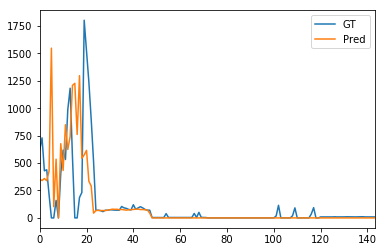

In [212]:
#pd.Series(train_appliance[0]).plot()
pd.Series(train_all_appliances[0]).plot(label='GT')
pd.Series(model.predict(test_agg)[0, :]).plot(label='Pred')
plt.legend()

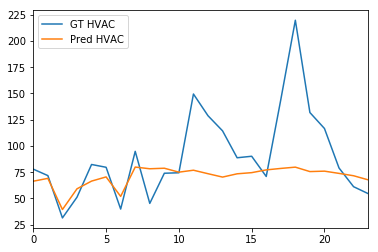

In [215]:
#pd.Series(test_agg[1, :]).plot(label='GT Agg')
#pd.Series(test_hvac[1, :]).plot(label='GT HVAC')
pd.Series(test_fridge[1, :]).plot(label='GT HVAC')


#pd.Series(test_fridge[1, :]).plot(label='GT Fridge')


#pd.Series(test_mw[1, :]).plot(label='GT MW')
#pd.Series(test_oven[1, :]).plot(label='GT Oven')







#pd.Series(model.predict(test_agg[1:2])[0, :24]).plot(label='Pred HVAC')
pd.Series(model.predict(test_agg[1:2])[0, 24:48]).plot(label='Pred HVAC')


#pd.Series(model.predict(test_agg[1:2])[0, 24:]).plot(label='Pred Fridge')




plt.legend()

In [216]:
print(np.mean(pred_fridge), np.mean(test_fridge))
np.mean(pred_hvac), np.mean(test_hvac), np.mean(test_agg)

83.6465 88.9532061557


(1034.436, 937.65674098776663, 1072.7840002015712)

In [217]:
(pd.DataFrame(test_fridge)-pd.DataFrame(pred_fridge)).abs().sum(axis=1).argmax()

137

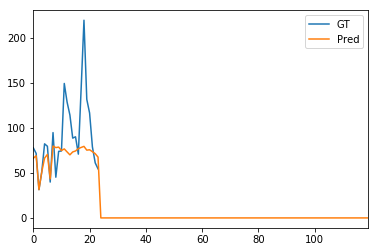

In [218]:
pd.Series(test_fridge[1, :]).plot(label='GT')
pd.Series(model.predict(test_agg_new[1:2])[0, 24:]).plot(label='Pred')


plt.legend()